# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [353]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [354]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 19, 10, 22, 9, 580456)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [355]:
#try:
#    with open('../../data/hopsworks-api-key.txt', 'r') as file:
#        os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
#except FileNotFoundError:
#    pass  # If the file is not found do nothing
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1162395
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [356]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=2,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [357]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=6,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [358]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.277592E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [359]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=2,
)


In [360]:
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.98s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-21 00:00:00+00:00,17.600000,0.0,11.928989,264.805664,Zaragoza
1,2024-11-20 00:00:00+00:00,14.400000,0.0,21.028437,321.952911,Zaragoza
2,2024-11-23 00:00:00+00:00,13.400000,0.0,16.981165,94.864426,Zaragoza
3,2024-11-22 00:00:00+00:00,12.650000,0.0,29.568253,312.038971,Zaragoza
4,2024-11-24 00:00:00+00:00,16.950001,0.0,17.373497,95.946770,Zaragoza
5,2024-11-25 00:00:00+00:00,16.299999,0.0,10.296251,306.469330,Zaragoza
6,2024-11-26 00:00:00+00:00,15.750000,0.0,5.315336,118.300667,Zaragoza
7,2024-11-27 00:00:00+00:00,15.600000,0.0,1.800000,36.869991,Zaragoza


In [361]:
#compute 1 day before today
air_quality_df = air_quality_fg.filter(air_quality_fg.date >= today - datetime.timedelta(3)).read()
air_quality_df = air_quality_df.sort_values(by='date', ascending=True)
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.71s) 


,date,pm25,historic,country,city,street,url
0,2024-11-17 00:00:00+00:00,52.0,43.000000,Spain,Zaragoza,Las Fuentes,https://api.waqi.info/feed/@11996
1,2024-11-18 00:00:00+00:00,48.0,48.666668,Spain,Zaragoza,Las Fuentes,https://api.waqi.info/feed/@11996


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [362]:
batch_data = batch_data.sort_values(by=['date'], ascending=True)
air_quality_df = air_quality_df.sort_values(by='date', ascending=True)
historic = air_quality_df['pm25'].values.mean()
pm25_values = air_quality_df['pm25'].values.tolist()

# Iterate through the rows (future weather predictions) in batch_data adding the historic PM2.5 values and predicting the PM2.5 values
for index, row in batch_data.iterrows():
    batch_data.loc[index, 'historic'] = historic
    row['historic'] = historic

    predicted_value = retrieved_xgboost_model.predict(row[['historic', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']].apply(pd.to_numeric, errors='coerce').to_frame().T)[0]
    
    batch_data.loc[index,'predicted_pm25'] = predicted_value
    pm25_values.append(predicted_value)
    
    # Calculate the rolling mean of the last 3 predicted PM2.5 values
    historic = sum(pm25_values[-3:]) / 3 if pm25_values else 0
batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,historic,predicted_pm25
1,2024-11-20 00:00:00+00:00,14.400000,0.0,21.028437,321.952911,Zaragoza,50.000000,66.259422
0,2024-11-21 00:00:00+00:00,17.600000,0.0,11.928989,264.805664,Zaragoza,55.419807,37.695377
3,2024-11-22 00:00:00+00:00,12.650000,0.0,29.568253,312.038971,Zaragoza,50.651600,20.292089
2,2024-11-23 00:00:00+00:00,13.400000,0.0,16.981165,94.864426,Zaragoza,41.415630,53.591694
4,2024-11-24 00:00:00+00:00,16.950001,0.0,17.373497,95.946770,Zaragoza,37.193054,35.070778
5,2024-11-25 00:00:00+00:00,16.299999,0.0,10.296251,306.469330,Zaragoza,36.318187,41.461205
6,2024-11-26 00:00:00+00:00,15.750000,0.0,5.315336,118.300667,Zaragoza,43.374559,39.321110
7,2024-11-27 00:00:00+00:00,15.600000,0.0,1.800000,36.869991,Zaragoza,38.617697,40.282661


In [363]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 1 to 7
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   historic                     8 non-null      float64            
 7   predicted_pm25               8 non-null      float64            
dtypes: datetime64[us, UTC](1), float32(4), float64(2), object(1)
memory usage: 748.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [364]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,historic,predicted_pm25,street,country,days_before_forecast_day
1,2024-11-20 00:00:00+00:00,14.400000,0.0,21.028437,321.952911,Zaragoza,50.000000,66.259422,Las Fuentes,Spain,1
0,2024-11-21 00:00:00+00:00,17.600000,0.0,11.928989,264.805664,Zaragoza,55.419807,37.695377,Las Fuentes,Spain,2
3,2024-11-22 00:00:00+00:00,12.650000,0.0,29.568253,312.038971,Zaragoza,50.651600,20.292089,Las Fuentes,Spain,3
2,2024-11-23 00:00:00+00:00,13.400000,0.0,16.981165,94.864426,Zaragoza,41.415630,53.591694,Las Fuentes,Spain,4
4,2024-11-24 00:00:00+00:00,16.950001,0.0,17.373497,95.946770,Zaragoza,37.193054,35.070778,Las Fuentes,Spain,5
5,2024-11-25 00:00:00+00:00,16.299999,0.0,10.296251,306.469330,Zaragoza,36.318187,41.461205,Las Fuentes,Spain,6
6,2024-11-26 00:00:00+00:00,15.750000,0.0,5.315336,118.300667,Zaragoza,43.374559,39.321110,Las Fuentes,Spain,7
7,2024-11-27 00:00:00+00:00,15.600000,0.0,1.800000,36.869991,Zaragoza,38.617697,40.282661,Las Fuentes,Spain,8


In [365]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 1 to 7
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         8 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          8 non-null      float32            
 2   precipitation_sum            8 non-null      float32            
 3   wind_speed_10m_max           8 non-null      float32            
 4   wind_direction_10m_dominant  8 non-null      float32            
 5   city                         8 non-null      object             
 6   historic                     8 non-null      float64            
 7   predicted_pm25               8 non-null      float64            
 8   street                       8 non-null      object             
 9   country                      8 non-null      object             
 10  days_before_forecast_day     8 non-null      int64         

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

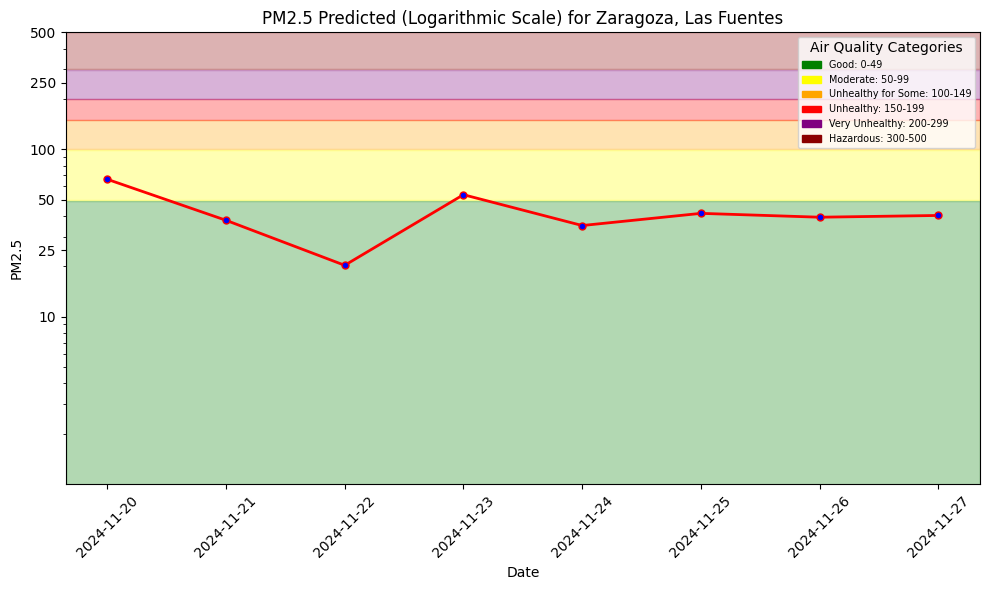

In [366]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [367]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [368]:
#convert 
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/8 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1162395/jobs/named/aq_predictions_2_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x285c74a90>, None)

In [369]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.21s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,historic,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-19 00:00:00+00:00,15.35,0.0,8.669949,274.763550,Zaragoza,48.666668,43.822559,Las Fuentes,Spain,1
1,2024-11-20 00:00:00+00:00,14.40,0.0,21.028437,321.952911,Zaragoza,50.000000,66.259422,Las Fuentes,Spain,1


In [370]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=2,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.28s) 


,date,pm25,historic,country,city,street,url
0,2024-03-03 00:00:00+00:00,12.0,17.000000,Spain,Zaragoza,Las Fuentes,https://api.waqi.info/feed/@11996
1,2024-10-05 00:00:00+00:00,33.0,33.333332,Spain,Zaragoza,Las Fuentes,https://api.waqi.info/feed/@11996
2,2024-04-13 00:00:00+00:00,49.0,29.000000,Spain,Zaragoza,Las Fuentes,https://api.waqi.info/feed/@11996
3,2023-12-04 00:00:00+00:00,23.0,19.666666,Spain,Zaragoza,Las Fuentes,https://api.waqi.info/feed/@11996
4,2024-09-24 00:00:00+00:00,48.0,33.666668,Spain,Zaragoza,Las Fuentes,https://api.waqi.info/feed/@11996
...,...,...,...,...,...,...,...
369,2024-11-17 00:00:00+00:00,52.0,43.000000,Spain,Zaragoza,Las Fuentes,https://api.waqi.info/feed/@11996
370,2024-11-16 00:00:00+00:00,46.0,38.333332,Spain,Zaragoza,Las Fuentes,https://api.waqi.info/feed/@11996
371,2024-11-01 00:00:00+00:00,32.0,38.000000,Spain,Zaragoza,Las Fuentes,https://api.waqi.info/feed/@11996
372,2024-11-02 00:00:00+00:00,50.0,35.333332,Spain,Zaragoza,Las Fuentes,https://api.waqi.info/feed/@11996


In [371]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

query = weather_fg.select_all()
selected_features = air_quality_fg.select(['historic']).join(query, on=['city'])
#transform historic to double
#selected_features = selected_features.withColumn("historic", selected_features["historic"].cast("double"))
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.47s) 


,historic,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,10.666667,2023-11-05 00:00:00+00:00,14.648582,0.0,32.169178,264.592468,Zaragoza
1,14.000000,2023-11-06 00:00:00+00:00,12.263165,0.0,19.734436,261.058289,Zaragoza
2,16.000000,2023-11-07 00:00:00+00:00,9.800666,0.4,17.339897,266.493042,Zaragoza
3,23.000000,2023-11-08 00:00:00+00:00,11.750667,0.0,12.864649,243.296295,Zaragoza
4,28.000000,2023-11-09 00:00:00+00:00,12.265251,5.3,21.461555,289.662323,Zaragoza
5,32.666668,2023-11-10 00:00:00+00:00,14.088165,0.0,21.629978,271.008606,Zaragoza
6,33.333332,2023-11-11 00:00:00+00:00,15.969417,2.8,29.986076,274.807892,Zaragoza
7,30.333334,2023-11-12 00:00:00+00:00,17.615252,0.0,28.476431,277.578400,Zaragoza
8,27.000000,2023-11-13 00:00:00+00:00,18.515251,0.0,18.356470,253.027969,Zaragoza
9,27.666666,2023-11-14 00:00:00+00:00,18.177748,0.0,19.652176,267.528839,Zaragoza


In [372]:
def backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, model):
    features_df = weather_fg.read()
    features_df = features_df.sort_values(by=['date'], ascending=True)
    features_df = features_df.tail(10)

    features_df['predicted_pm25'] = model.predict(
        features_df[['historic', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']].apply(pd.to_numeric, errors='coerce'))
    df = pd.merge(features_df, air_quality_df[[
                  'date', 'pm25', 'street', 'country']], on="date")
    df['days_before_forecast_day'] = 1
    hindcast_df = df
    # do a try catch for the case when the column already exists
    df = df.drop('pm25', axis=1)
    #transform'predicted_pm25' and 'historic' to double
    df['predicted_pm25'] = df['predicted_pm25'].astype('Float64')
    df['historic'] = df['historic'].astype('Float64')
    monitor_fg.insert(df, write_options={"wait_for_job": True})
    return hindcast_df


In [374]:

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(selected_features, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.78s) 


Uploading Dataframe: 0.00% |          | Rows 0/10 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1162395/jobs/named/aq_predictions_2_offline_fg_materialization/executions


,historic,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25,street,country,days_before_forecast_day
0,48.000000,2024-11-09 00:00:00+00:00,14.069417,0.0,21.029209,290.008331,Zaragoza,41.790852,42.0,Las Fuentes,Spain,1
1,42.000000,2024-11-10 00:00:00+00:00,13.975667,0.0,20.917982,286.648407,Zaragoza,18.384651,18.0,Las Fuentes,Spain,1
2,33.000000,2024-11-11 00:00:00+00:00,13.750668,0.0,24.822384,298.067383,Zaragoza,28.899977,29.0,Las Fuentes,Spain,1
3,29.666666,2024-11-12 00:00:00+00:00,11.204833,0.0,33.233284,302.941284,Zaragoza,17.592991,21.0,Las Fuentes,Spain,1
4,22.666666,2024-11-13 00:00:00+00:00,9.056917,0.1,11.700000,281.852203,Zaragoza,32.132366,32.0,Las Fuentes,Spain,1
5,27.333334,2024-11-14 00:00:00+00:00,12.279832,0.0,8.596766,265.832886,Zaragoza,34.994175,35.0,Las Fuentes,Spain,1
6,29.333334,2024-11-15 00:00:00+00:00,11.856917,0.0,10.404249,104.715996,Zaragoza,46.730625,48.0,Las Fuentes,Spain,1
7,38.333332,2024-11-16 00:00:00+00:00,11.577750,0.0,7.353611,121.883507,Zaragoza,46.039005,46.0,Las Fuentes,Spain,1
8,43.000000,2024-11-17 00:00:00+00:00,15.000000,0.0,13.708391,283.671326,Zaragoza,51.900764,52.0,Las Fuentes,Spain,1
9,48.666668,2024-11-18 00:00:00+00:00,15.500000,0.0,11.918120,295.016846,Zaragoza,47.916981,48.0,Las Fuentes,Spain,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

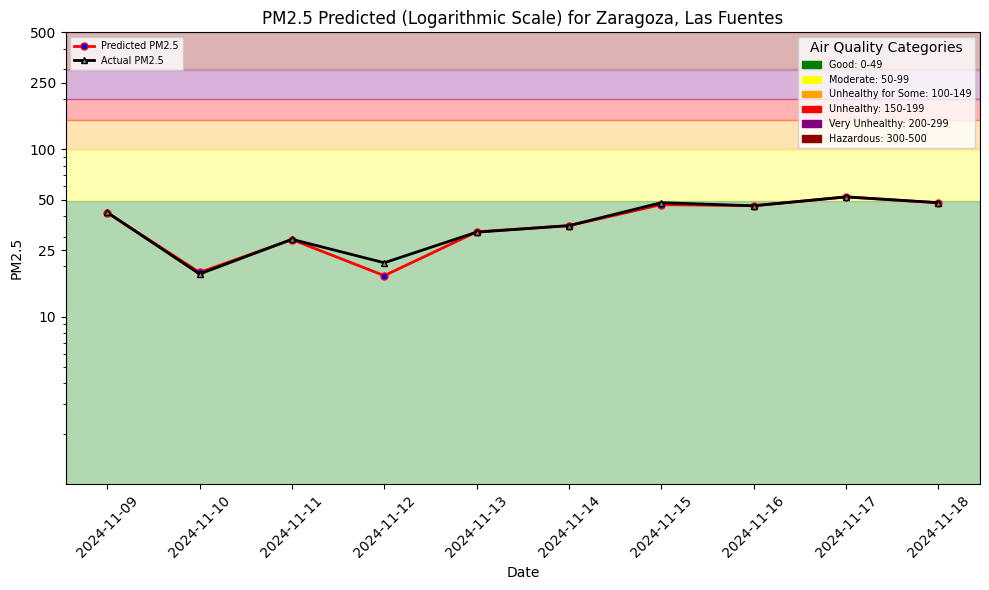

In [375]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---